In [1]:
import sys
import fire
import h5py
from matplotlib import pyplot as plt
import torch.utils.data as utils    
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage import morphology as morph
from scipy.ndimage import label as scilabel
# from skimage.external.tifffile import imread as tiff_read
from scipy.ndimage.morphology import binary_fill_holes as fill_holes
from skimage import measure
# import glymur
import time
import pickle
import scipy.misc
###########Neural net modules
# import torch
from scipy import misc
import numpy as np
# from torchvision import datasets, models, transforms
import os
from tqdm import trange, tqdm
import sys, os
sys.path.insert(0,os.path.abspath("PathPretrain"))
import GPUtil
from train_model import train_model, generate_transformers, generate_kornia_transforms
from torch.utils.data import Dataset
import torch, pandas as pd, numpy as np
from PIL import Image
import seaborn as sns, matplotlib
from scipy.special import softmax

seg_model="segmentation_practice/seg_model/10.checkpoint.pth"#30.
class4_model="checkpoints_class4/20.checkpoint.pth"
class1_model="checkpoints_class1/8.checkpoint.pth"
class2_model="checkpoints_class2/166.checkpoint.pth"
class3_model="checkpoints_class3/206.checkpoint.pth"
EPS=1e-8

class WSI_Dataset(Dataset):
    def __init__(self, stats_dict, transform):
        imgs=pd.Series([stats_dict[i]['colorimage'] for i in range(len(stats_dict))])
        shapes=np.array(imgs.map(lambda x: x.shape).tolist())
        include_image=np.logical_and(shapes[:,0]>=4, shapes[:,1]>=4, np.logical_or(shapes[:,0]>=10,shapes[:,1]>=10))
        imgs=imgs[include_image]#.map(lambda x: x.astype(float)/255.)
        self.to_pil=lambda x: Image.fromarray(x)
        self.X=imgs.tolist()
        self.retained_idx=np.where(include_image)[0]
        self.length=len(self.X)
        self.transform=transform
        
    def __getitem__(self,idx):
        X=self.transform(self.to_pil(self.X[idx]))
        return X,torch.zeros(X.shape[-2:]).unsqueeze(0).long()
    
    def __len__(self):
        return self.length

def im_resizer(I, scale_percent):
	import numpy as np
	import cv2
	# width = int(I.shape[1] * scale_percent / 100)
	# height = int(I.shape[0] * scale_percent / 100)

	I1 = I[0:int(I.shape[0]/2), :, :].copy()
	I2 = I[int(I.shape[0]/2):, :, :].copy()
	del I

	h1 = int(I1.shape[0] * (scale_percent / 100))
	w1 = int(I1.shape[1] * (scale_percent / 100))
	h2 = int(I2.shape[0] * (scale_percent / 100))
	w2 = int(I2.shape[1] * (scale_percent / 100))

	print(h1,w1,h2,w2)

	I1 = cv2.resize(I1, (w1, h1), interpolation = cv2.INTER_CUBIC)
	I2 = cv2.resize(I2, (w2, h2), interpolation = cv2.INTER_CUBIC)

	# init resized array
	I = 255*np.ones((h1+h2, w1, 3), dtype='uint8')
	print(I1.shape, I2.shape)
	# merge resized sub arrayss
	I[0:h1, 0:w1, :] = I1

	del I1
	I[h1:h1+h2, 0:w1, :] = I2
	del I2
	print(I.shape)
	return(I)

def stats_maker(path, resize = 0):

    if path.split('.')[-1] == 'h5':
        I = h5_load(path)
    elif path.split('.')[-1] == 'jp2':
        import glymur
        jp2 = glymur.Jp2k(path)
        I = jp2[:]
    elif path.split('.')[-1] == 'tif':
        I = tiff_read(path)
    elif path.split('.')[-1] == 'npy':
        I = np.load(path)
    
    scale_percent = 50
    width = int(I.shape[1] * scale_percent / 100)
    height = int(I.shape[0] * scale_percent / 100)
    
#     print('Image too big for cv2: Splitting')
#     I1 = I[0:int(I.shape[0]/2), :, :].copy()
#     I2 = I[int(I.shape[0]/2):, :, :].copy()
#     del I
    
#     if resize == 1:
#         h1 = int(I1.shape[0]/2)
#         w1 = int(I1.shape[1]/2)
#         h2 = int(I2.shape[0]/2)
#         w2 = int(I2.shape[1]/2)
#     elif resize == 0:
#         h1 = int(I1.shape[0])
#         w1 = int(I1.shape[1])
#         h2 = int(I2.shape[0])
#         w2 = int(I2.shape[1])
    
#     print(h1,w1,h2,w2)
    
    I[(I[:,:,0]>220) & (I[:,:,1]>220) & (I[:,:,2]>220)]=[255,255,255]
    
#     if resize == 1:
#         I1 = cv2.resize(I1, (w1, h1), interpolation = cv2.INTER_CUBIC)
#     I1[(I1[:,:,0]>220) & (I1[:,:,1]>220) & (I1[:,:,2]>220)]=[255,255,255]
#     if resize == 1:
#         I2 = cv2.resize(I2, (w2, h2), interpolation = cv2.INTER_CUBIC)
#     I2[(I2[:,:,0]>220) & (I2[:,:,1]>220) & (I2[:,:,2]>220)]=[255,255,255]

    # init resized array
#     I = 255*np.ones((h1+h2, w1, 3), dtype='uint8')
#     print(I1.shape, I2.shape)
#     # merge resized sub arrays
#     I[0:h1, 0:w1, :] = I1
    
#     del I1
#     I[h1:h1+h2, 0:w1, :] = I2
#     del I2
    print(I.shape)
        
    tops = 255*np.ones((1, I.shape[1], 3), dtype='uint8')
    I = np.vstack((tops, I))
    I = np.vstack((I, tops))
    sides = 255*np.ones((I.shape[0], 1, 3), dtype='uint8')
    I = np.hstack((sides, I))
    I = np.hstack((I, sides))
    
    BW = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
    BW2 = cv2.cvtColor(I, cv2.COLOR_RGB2GRAY)
#     print(1)
    BW[BW<255]=1
    BW2[BW2<255]=1
#     print(2)
    BW[BW==255]=0
    BW2[BW2==255]=0
#     print(3)
    labels = scilabel(BW)[0]
    labels2 = scilabel(BW2)[0]
#     print(4)
    BW = morph.remove_small_objects(labels, min_size=50, connectivity = 8, in_place=True) # may want to do this compressed then upsample?
    BW2 = morph.remove_small_objects(labels2, min_size=500000, connectivity = 8, in_place=True)
    del labels
    del labels2
#     print(5)
    BW[BW2!=0]=0
    del BW2
    BW = fill_holes(BW)
#     print(6)
    I[BW!=1]=[255,255,255]
#     print(7)
    labels = scilabel(BW)[0]
    del BW
    stats = measure.regionprops(labels, coordinates='rc')
    del labels
    
    stats_dict = {num:{} for num in range(len(stats))}
    for r in trange(len(stats_dict)):
#         if not r%1000:
#             print(r / len(stats))
        for key in stats[r]:
            stats_dict[r][key] = stats[r][key]
        minr = stats[r].bbox[0]
        maxr = stats[r].bbox[2]
        minc = stats[r].bbox[1]
        maxc = stats[r].bbox[3]
        img = I[minr:maxr, minc:maxc, :].copy()
        img[stats[r].image!=1]=[255,255,255]
        stats_dict[r]['colorimage'] = img

    stats = stats_dict
    #Dict of all subimages and statistics / coordinates
    return(stats)

def return_results(wsi_file='wsi.npy',out_dir='out_dir',gpu_id=0):
    os.makedirs(out_dir,exist_ok=True)
    basename=os.path.basename(wsi_file)
    st_test=stats_maker(wsi_file, resize = 0)
    transform=generate_transformers(256,256)['test']
    custom_dataset=WSI_Dataset(st_test,transform)
    Y_seg=train_model(inputs_dir='segmentation_practice/inputs',
                architecture='resnet50',
                batch_size=256,
                num_classes=3,
                predict=True,
                model_save_loc=seg_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=gpu_id,
                tensor_dataset=False,
                semantic_segmentation=True,
                custom_dataset=custom_dataset,
                save_predictions=False)
    transform=generate_transformers(224,256)['test']
    custom_dataset=WSI_Dataset(st_test,transform)
    Y_class1=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=256,
                predict=True,
                num_classes=4,
                model_save_loc=class4_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                pickle_dataset=True,
                semantic_segmentation=False,
                custom_dataset=custom_dataset,
                save_predictions=False)
    Y_class2=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=256,
                predict=True,
                num_classes=2,
                model_save_loc=class3_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=gpu_id,
                tensor_dataset=False,
                pickle_dataset=True,
                semantic_segmentation=False,
                custom_dataset=custom_dataset,
                save_predictions=False)
    Y=dict(seg=Y_seg['pred'],
      class1=Y_class1['pred'],
      class2=Y_class2['pred'])
    
    calc_nc_ratio=lambda x: (x==2).sum()/(((x==1).sum()+(x==2).sum()+EPS))#+(x==2).sum()

    include_images=(Y['class1'].argmax(1)==0) # deactivate class2 to get urothelial only
    nc_ratio,atypia_score=np.array([calc_nc_ratio(y.argmax(0)) for y in Y['seg'][include_images]]),softmax(Y['class2'][include_images],1)[:,1]

    pd.DataFrame(dict(atypia=atypia_score,
                     nc=nc_ratio)).to_pickle(os.path.join(out_dir,f"{basename[:basename.rfind('.')]}.pkl"))

# if __name__=="__main__":
#     fire.Fire(return_results)

nonechucks may not work properly with this version of PyTorch (1.6.0). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [2]:
# ! ls -lah example_full_scans/ # see example_full_scans/example_RIM

In [3]:
wsi_file="example_full_scans/sus_102_1_08_R_orig.npy"#aty_103_28_17_R_orig.npy
st_test=stats_maker(wsi_file, resize = 0) # redo this command

(25378, 28884, 3)


/home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:180: FutureWarning:

The coordinates keyword argument to skimage.measure.regionprops is deprecated. All features are now computed in rc (row-column) coordinates. Please remove `coordinates="rc"` from all calls to regionprops before updating scikit-image.

100%|██████████| 110494/110494 [04:02<00:00, 455.20it/s]


In [14]:
type(st_test[0]['area'])

numpy.int64

In [7]:
include_cells=np.array([True]*len(st_test))
cell_stats=pd.DataFrame([{k:v for k,v in st_test[i].items() if isinstance(v,(np.int64,int,float,tuple)) and k not in ['slice','local_centroid']} for i in tqdm(np.arange(len(st_test))[include_cells])])



100%|██████████| 110494/110494 [00:01<00:00, 101349.75it/s]


In [8]:
cell_stats

,area,bbox,bbox_area,centroid,convex_area,eccentricity,equivalent_diameter,euler_number,extent,feret_diameter_max,filled_area,label,major_axis_length,minor_axis_length,orientation,perimeter,perimeter_crofton,solidity
0,32834,"(1, 3473, 172, 3713)",41040,"(78.52856794785893, 3590.9096363525614)",34203,0.676489,204.464049,1,0.800049,242.684981,32834,1,239.995773,176.745639,-1.420175,1077.305699,1159.324783,0.959974
1,123,"(1, 6997, 17, 7018)",336,"(7.845528455284553, 7004.804878048781)",204,0.894200,12.514330,1,0.366071,24.413111,123,2,23.754893,10.634289,-0.840756,75.112698,79.255855,0.602941
2,1107,"(1, 7043, 68, 7102)",3953,"(29.9159891598916, 7067.411924119241)",2363,0.904311,37.542991,1,0.280040,78.032045,1107,3,79.066929,33.751569,-0.475297,423.611219,405.664583,0.468472
3,433,"(1, 7113, 39, 7145)",1216,"(16.755196304849886, 7128.025404157044)",768,0.816041,23.480049,1,0.356086,43.046487,433,4,42.079821,24.321857,0.550903,190.373629,188.563757,0.563802
4,53,"(1, 7137, 11, 7146)",90,"(5.037735849056604, 7141.0)",69,0.556858,8.214724,1,0.588889,11.180340,53,5,10.195855,8.468759,-0.452691,34.727922,37.731808,0.768116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110489,78,"(25367, 17577, 25379, 17595)",216,"(25371.29487179487, 17584.75641025641)",157,0.699940,9.965575,1,0.361111,18.439089,78,110490,17.754619,12.680376,-1.549009,58.485281,81.937372,0.496815
110490,109,"(25367, 23013, 25378, 23025)",132,"(25372.174311926607, 23018.697247706423)",111,0.389381,11.780624,1,0.825758,13.000000,109,110491,12.266501,11.298392,1.408708,35.556349,36.391050,0.981982
110491,104,"(25367, 25346, 25379, 25360)",168,"(25371.884615384617, 25352.78846153846)",134,0.553448,11.507255,1,0.619048,15.264338,104,110492,13.356486,11.124397,1.110008,51.041631,55.486992,0.776119
110492,74,"(25368, 22826, 25378, 22836)",100,"(25372.702702702703, 22830.527027027027)",80,0.310778,9.706685,1,0.740000,10.770330,74,110493,9.974836,9.480908,1.372243,30.142136,31.258054,0.925000


In [43]:
# arr_counts
pd.concat([pd.Series(x).value_counts() for x in [[1]*2+[3]*3,[1]*2+[0]*4]],axis=1).T.fillna(0)

,0,1,3
0,0.0,2.0,3.0
1,4.0,2.0,0.0


In [39]:
arr_counts

True     34203
False     6837
True       204
False      132
True      2363
         ...  
False       34
True        80
False       20
True        90
False       42
Length: 220986, dtype: int64

In [44]:
# %%timeit
arr_counts=pd.concat([pd.Series(st_test[i]['convex_image'].flatten()).value_counts() for i in tqdm(np.arange(len(st_test))[include_cells])],axis=1).T.fillna(0)
                      
                      
                      

100%|██████████| 110494/110494 [00:48<00:00, 2292.08it/s]


In [45]:
arr_counts

,True,False
0,34203.0,6837.0
1,204.0,132.0
2,2363.0,1590.0
3,768.0,448.0
4,69.0,21.0
...,...,...
110489,157.0,59.0
110490,111.0,21.0
110491,134.0,34.0
110492,80.0,20.0


In [32]:
%%timeit

# from collections import Counter

Counter(st_test[0]['convex_image'].flatten())

2.62 ms ± 215 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
# import matplotlib.pyplot as plt

# plt.imshow(st_test[500]['colorimage'])

In [9]:
# ! cd PathPretrain && git pull

In [3]:
# d=pickle.load(open("tmp_test.pkl",'rb'))

nonechucks may not work properly with this version of PyTorch (1.6.0). It has only been tested on PyTorch versions 1.0, 1.1, and 1.2


In [14]:
transform=generate_transformers(256,256)['test']
custom_dataset=WSI_Dataset(st_test,transform)

In [15]:
Y_seg=train_model(inputs_dir='segmentation_practice/inputs',
                architecture='resnet50',
                batch_size=256,
                num_classes=3,
                predict=True,
                model_save_loc=seg_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                semantic_segmentation=True,
                custom_dataset=custom_dataset,
                save_predictions=False)

270it [03:29,  1.29it/s]                         


In [ ]:
transform=generate_transformers(224,256)['test']
custom_dataset=WSI_Dataset(st_test,transform)

In [16]:
Y_class1=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=256,
                predict=True,
                num_classes=4,
                model_save_loc=class4_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                pickle_dataset=True,
                semantic_segmentation=False,
                custom_dataset=custom_dataset,
                save_predictions=False)

270it [02:26,  1.85it/s]                         


In [17]:
Y_class2=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=256,
                predict=True,
                num_classes=2,
                model_save_loc=class3_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                pickle_dataset=True,
                semantic_segmentation=False,
                custom_dataset=custom_dataset,
                save_predictions=False)

270it [02:26,  1.84it/s]                         


In [18]:
Y=dict(seg=Y_seg['pred'],
      class1=Y_class1['pred'],
      class2=Y_class2['pred'])

In [21]:
EPS=1e-8
calc_nc_ratio=lambda x: (x==2).sum()/(((x==1).sum()+(x==2).sum()+EPS))#+(x==2).sum()

include_images=(Y['class1'].argmax(1)==0) # deactivate class2 to get urothelial only
nc_ratio,atypia_score=np.array([calc_nc_ratio(y.argmax(0)) for y in Y['seg'][include_images]]),softmax(Y['class2'][include_images],1)[:,1]

pd.DataFrame(dict(atypia=atypia_score,
                 nc=nc_ratio))

In [5]:
! ls */*.pkl

inputs/train_data.pkl
inputs/val_data.pkl
prelim_out_dir/aty_103_28_17_R_orig.pkl
prelim_out_dir/aty_41_5_13_R_orig.pkl
prelim_out_dir/aty_96_0_08_R_orig.pkl
prelim_out_dir/neg_100_3_10_R_orig.pkl
prelim_out_dir/neg_101_9_09_R_orig.pkl
prelim_out_dir/neg_135_1_08_R_orig.pkl
prelim_out_dir/neg_137_1_08_N_orig.pkl
prelim_out_dir/neg_18_4_14_N_orig.pkl
prelim_out_dir/neg_1_8_15_R_orig.pkl
prelim_out_dir/neg_31_12_15_N_orig.pkl
prelim_out_dir/neg_33_4_17_N_orig.pkl
prelim_out_dir/neg_40_5_13_N_orig.pkl
prelim_out_dir/neg_60_6_13_R_orig.pkl
prelim_out_dir/neg_70_12_14_N_orig.pkl
prelim_out_dir/neg_74_10_14_R_orig.pkl
prelim_out_dir/neg_95_9_10_N_orig.pkl
prelim_out_dir/pos_127_16_14_R_orig.pkl
prelim_out_dir/sus_102_1_08_R_orig.pkl
prelim_out_dir/sus_54_0_11_R_orig.pkl


/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(23.125, 0.5, 'Uncalibrated Atypia Score')

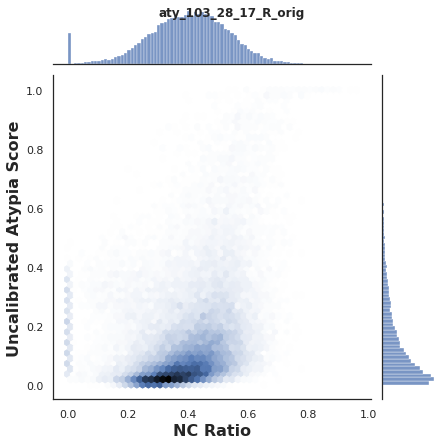

In [22]:


matplotlib.rcParams['figure.dpi']=300
sns.set(style='white')
%matplotlib inline
h = sns.jointplot(nc_ratio,atypia_score,kind='hex')#,xlim=[0,4])
h.set_axis_labels('x', 'y', fontsize=16)
plt.suptitle(os.path.basename(wsi_file).split(".")[0], fontweight='bold')
h.ax_joint.set_xlabel('NC Ratio', fontweight='bold')
h.ax_joint.set_ylabel('Uncalibrated Atypia Score', fontweight='bold')

Text(0, 0.5, 'Uncalibrated Atypia Score')

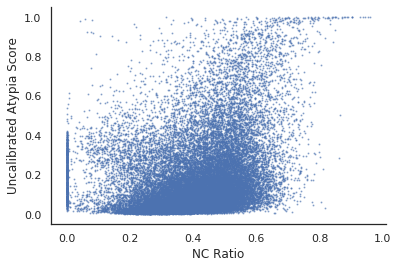

In [25]:
plt.scatter(nc_ratio,atypia_score,s=1,alpha=0.5)
sns.despine()
plt.xlabel('NC Ratio')
plt.ylabel('Uncalibrated Atypia Score')

Text(0.5, 1.0, 'Num. Cells=0')

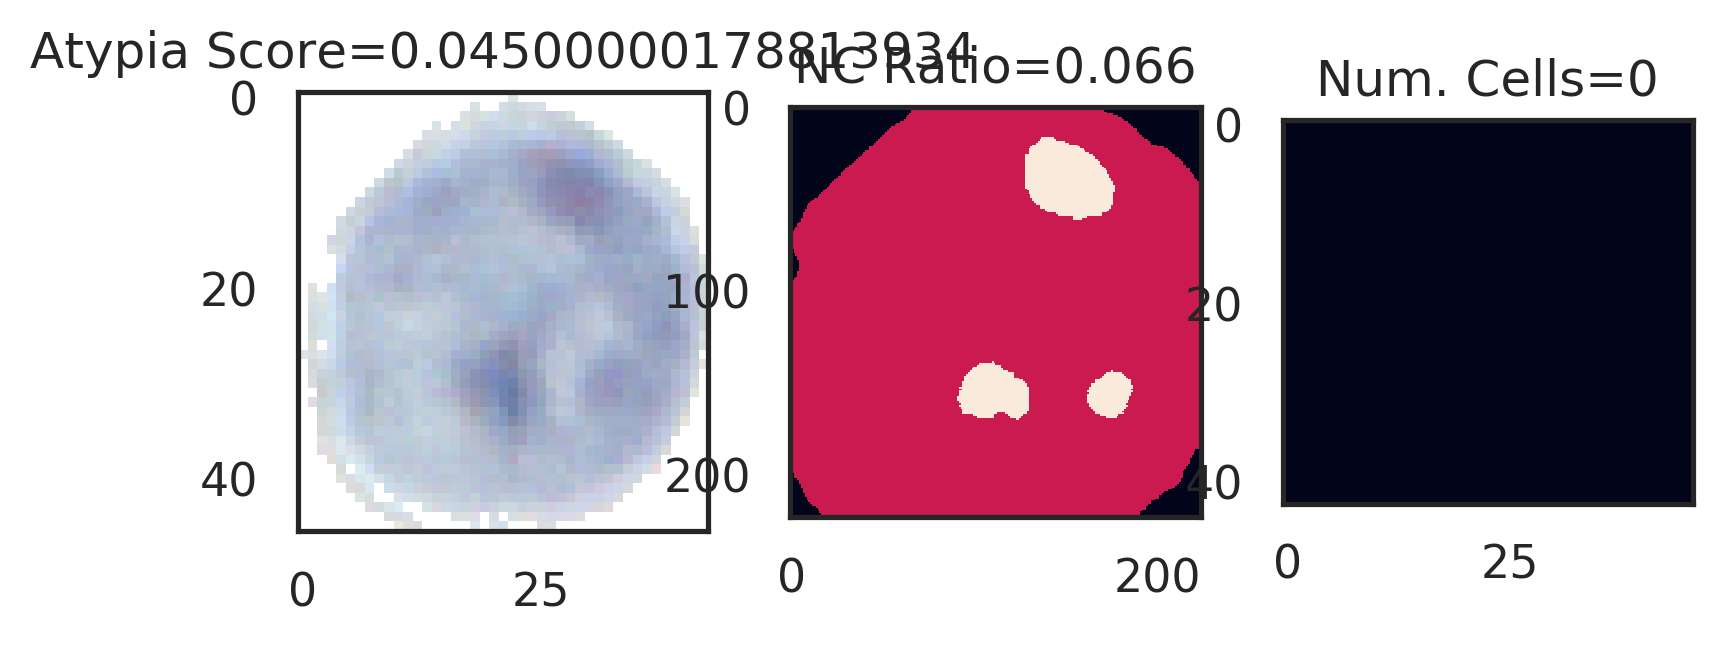

In [91]:
# decide later whether to do this

from scipy.ndimage.morphology import binary_erosion,binary_closing,binary_opening, binary_fill_holes
from skimage.morphology import disk
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
import cv2


matplotlib.rcParams['figure.dpi']=300
i=125
img_idx=np.where(include_images)[0]
img=img_idx[i]
seg_img=Y['seg'][img].argmax(0)
nuclei=(seg_img==2)
image=binary_erosion(binary_fill_holes(cv2.resize(nuclei.astype(int),dsize=st_test[img]['colorimage'].shape[:2],interpolation=cv2.INTER_NEAREST).astype(bool)),disk(3),iterations=2)
k=11
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((k, k)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

plt.subplot(131)
plt.imshow(st_test[img]['colorimage'])
plt.title(f"Atypia Score={round(atypia_score[i],3)}")
plt.subplot(132)
plt.imshow(seg_img)
plt.title(f"NC Ratio={round(nc_ratio[i],3)}")
plt.subplot(133)
plt.imshow(labels)#)
plt.title(f"Num. Cells={labels.max()}")

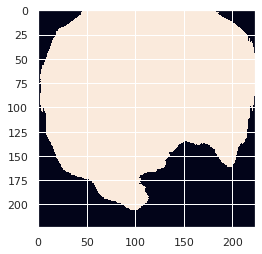

In [39]:
import matplotlib
%matplotlib inline
plt.imshow(Y['seg'][0].argmax(0))

In [ ]:
plt.imshow(custom_dataset[0][0].permute((1,2,0)).numpy())

In [9]:
Y_seg=train_model(inputs_dir='segmentation_practice/inputs',
                architecture='resnet50',
                batch_size=256,
                num_classes=3,
                predict=True,
                model_save_loc=seg_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                semantic_segmentation=True,
                custom_dataset=custom_dataset,
                save_predictions=False)

270it [03:29,  1.29it/s]                         


In [10]:
Y_class1=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=256,
                predict=True,
                num_classes=3,
                model_save_loc=class1_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                pickle_dataset=True,
                semantic_segmentation=False,
                custom_dataset=custom_dataset,
                save_predictions=False)

270it [02:25,  1.85it/s]                         


In [11]:
Y_class2=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=256,
                predict=True,
                num_classes=2,
                model_save_loc=class2_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                pickle_dataset=True,
                semantic_segmentation=False,
                custom_dataset=custom_dataset,
                save_predictions=False)

270it [02:25,  1.86it/s]                         


In [12]:
Y_class3=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=256,
                predict=True,
                num_classes=2,
                model_save_loc=class3_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                pickle_dataset=True,
                semantic_segmentation=False,
                custom_dataset=custom_dataset,
                save_predictions=False)

270it [02:25,  1.85it/s]                         


In [13]:
Y=dict(seg=Y_seg['pred'],
      class1=Y_class1['pred'],
      class2=Y_class2['pred'],
      class3=Y_class3['pred'])

/home/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



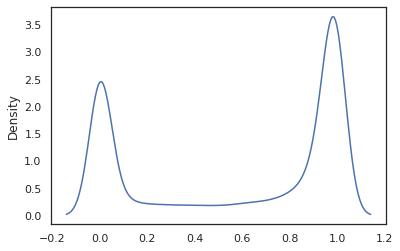

In [57]:
sns.kdeplot(softmax(Y['class1'],1)[:,0])

In [60]:
(Y['class1'].argmax(1)==0).sum()

42739

In [61]:
(Y['class2'].argmax(1)==0).sum()

2702

/home/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.

/home/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning:

Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.



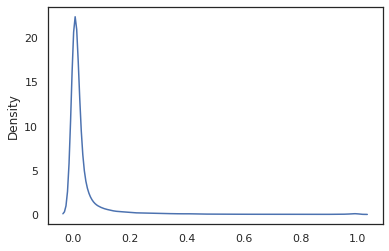

In [59]:
sns.kdeplot(softmax(Y['class2'],1)[Y['class1'].argmax(1)==0,0])

In [133]:
from scipy.special import softmax
EPS=1e-8
calc_nc_ratio=lambda x: (x==2).sum()/(((x==1).sum()+EPS))#+(x==2).sum()

include_images=(Y['class1'].argmax(1)==0) & (Y['class2'].argmax(1)==0) # deactivate class2 to get urothelial only
nc_ratio,atypia_score=np.array([calc_nc_ratio(y.argmax(0)) for y in Y['seg'][include_images]]),softmax(Y['class3'][include_images],1)[:,1]

p_urosquam=softmax(Y['class1'],1)

p_urothelial=softmax(Y['class2'],1)


In [111]:
Y['class2'].shape

(68988, 2)

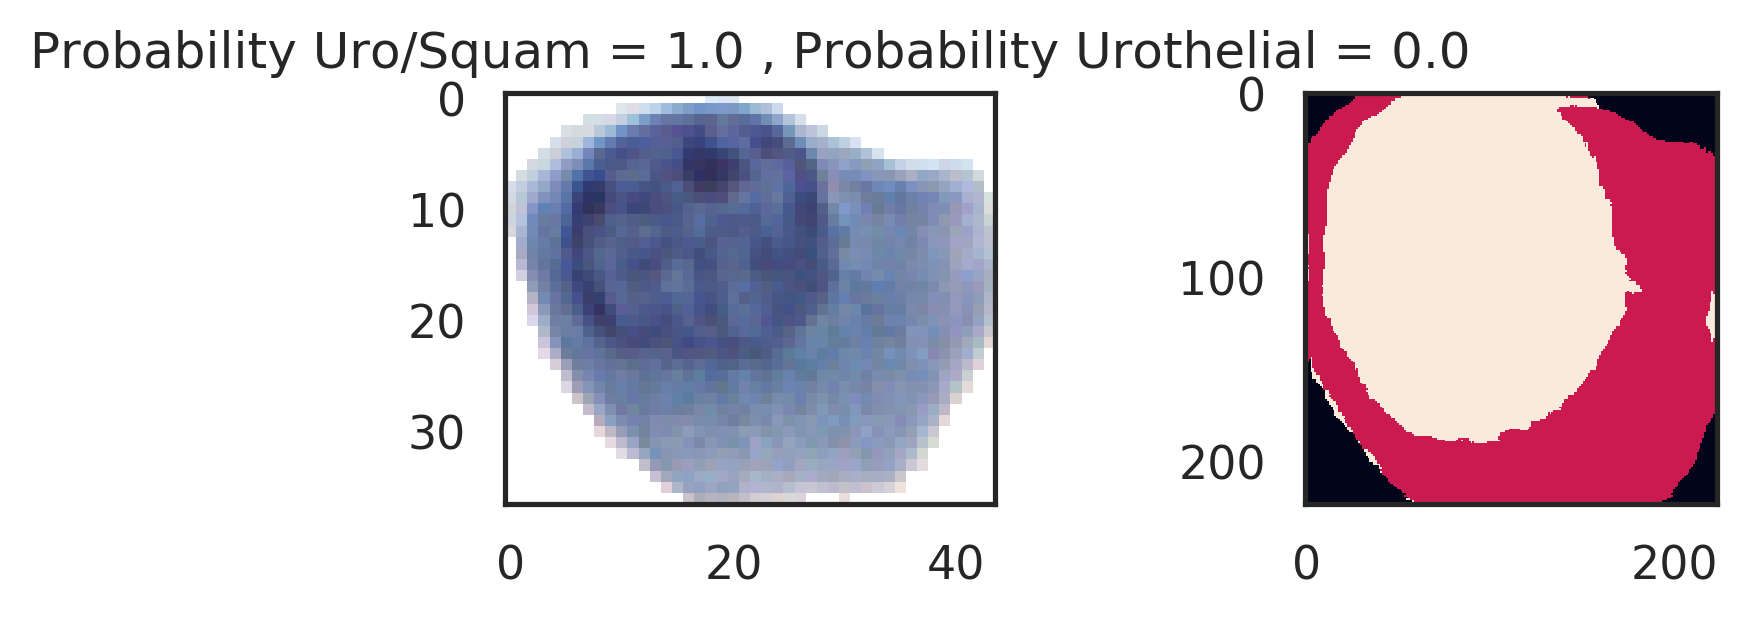

In [127]:
i=10563
img_idx=np.where(~include_images)[0]
img=img_idx[i]
plt.subplot(221)
plt.imshow(st_test[img]['colorimage'])
plt.title(f"Probability Uro/Squam = {round(p_urosquam[img,0],1)} , Probability Urothelial = {round(p_urothelial[img,0],1)}")
plt.subplot(222)
plt.imshow(Y['seg'][img].argmax(0))

Text(0.5, 1.0, 'NC Ratio=0.084')

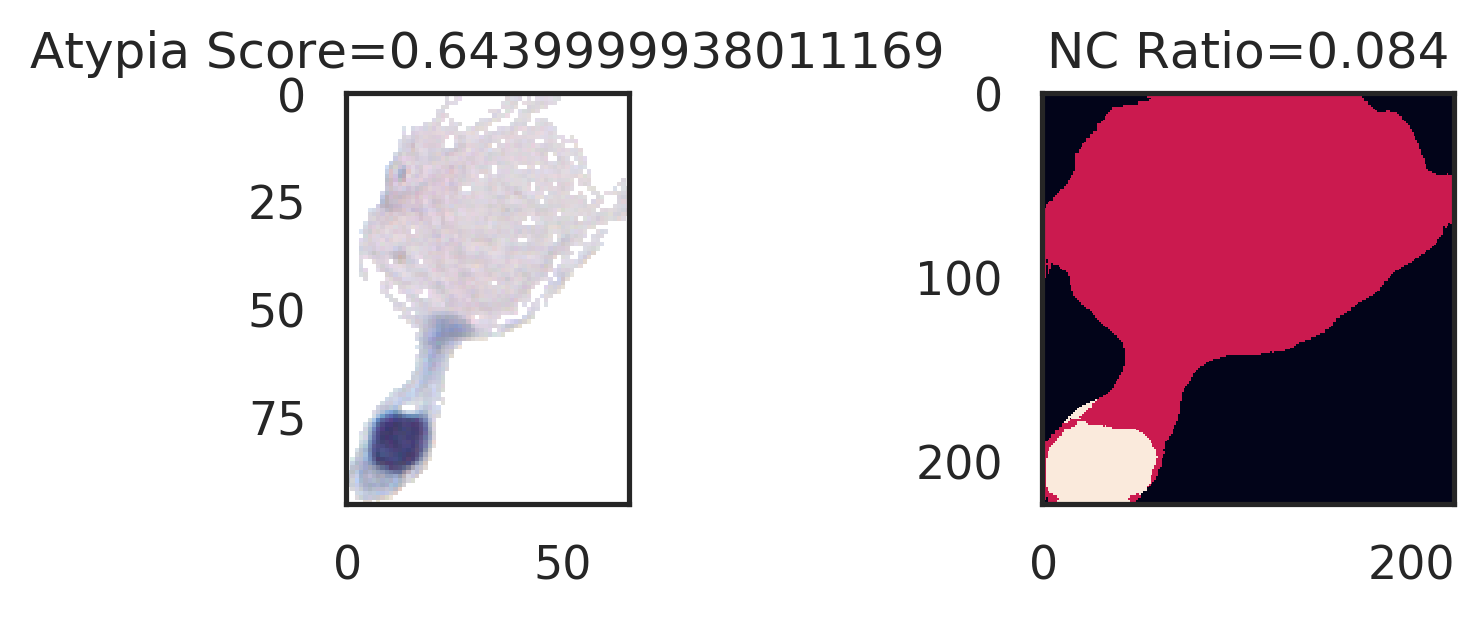

In [100]:
matplotlib.rcParams['figure.dpi']=300
i=134
img_idx=np.where(include_images)[0]
img=img_idx[i]
plt.subplot(221)
plt.imshow(st_test[img]['colorimage'])
plt.title(f"Atypia Score={round(atypia_score[i],3)}")
plt.subplot(222)
plt.imshow(Y['seg'][img].argmax(0))
plt.title(f"NC Ratio={round(nc_ratio[i],3)}")


In [54]:
sum(include_images)# nc_ratio

454

/dartfs-hpc/rc/home/w/f003k8w/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(23.125, 0.5, 'Uncalibrated Atypia Score')

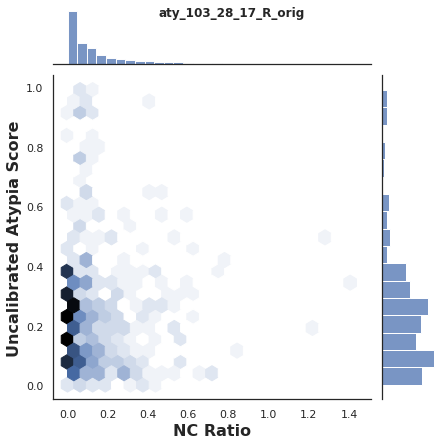

In [135]:
import seaborn as sns, matplotlib
matplotlib.rcParams['figure.dpi']=300
sns.set(style='white')
%matplotlib inline
h = sns.jointplot(nc_ratio,atypia_score,kind='hex')#,xlim=[0,4])
h.set_axis_labels('x', 'y', fontsize=16)
plt.suptitle(os.path.basename(wsi_file).split(".")[0], fontweight='bold')
h.ax_joint.set_xlabel('NC Ratio', fontweight='bold')
h.ax_joint.set_ylabel('Uncalibrated Atypia Score', fontweight='bold')


In [128]:
# putting it together

In [ ]:
def generate_rim_tabulation(wsi_file):
    st_test=stats_maker(wsi_file, resize = 0)
    transform=generate_transformers(224,256)['test']
    custom_dataset=WSI_Dataset(st_test,transform)
    
    Y_seg=train_model(inputs_dir='segmentation_practice/inputs',
                architecture='resnet50',
                batch_size=256,
                num_classes=3,
                predict=True,
                model_save_loc=seg_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                semantic_segmentation=True,
                custom_dataset=custom_dataset,
                save_predictions=False)
    
    Y_class1=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=256,
                predict=True,
                num_classes=3,
                model_save_loc=class1_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                pickle_dataset=True,
                semantic_segmentation=False,
                custom_dataset=custom_dataset,
                save_predictions=False)
    
    Y_class2=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=256,
                predict=True,
                num_classes=2,
                model_save_loc=class2_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                pickle_dataset=True,
                semantic_segmentation=False,
                custom_dataset=custom_dataset,
                save_predictions=False)
    
    Y_class3=train_model(inputs_dir='inputs',
                architecture='resnet50',
                batch_size=256,
                predict=True,
                num_classes=2,
                model_save_loc=class3_model,
                predictions_save_path='tmp_test.pkl',
                predict_set='custom',
                verbose=False,
                class_balance=False,
                gpu_id=0,
                tensor_dataset=False,
                pickle_dataset=True,
                semantic_segmentation=False,
                custom_dataset=custom_dataset,
                save_predictions=False)
    
    Y=dict(seg=Y_seg['pred'],
      class1=Y_class1['pred'],
      class2=Y_class2['pred'],
      class3=Y_class3['pred'])
    
    EPS=1e-8
    calc_nc_ratio=lambda x: (x==2).sum()/(((x==1).sum()+EPS))#+(x==2).sum()

    include_images=(Y['class1'].argmax(1)==0) & (Y['class2'].argmax(1)==0)
    nc_ratio,atypia_score=np.array([calc_nc_ratio(y.argmax(0)) for y in Y['seg'][include_images]]),softmax(Y['class3'][include_images],1)[:,1]

    p_urosquam=softmax(Y['class1'],1)

    p_urothelial=softmax(Y['class2'],1)
    
    return nc_ratio,atypia_score
# build an ML predictor off of the NC ratio and atypia scores for recurrence
# maybe can treat them as images of intensity or TDA desciptors which should capture atypia morphology and persistence